# Try a non-linear probe (few layer NN)

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

# create the model

In [2]:
from torch import nn
from typing import (List, Dict, Tuple)
import torch


class NonLinearModel(nn.Module):
    def __init__(
        self, input_size: int, 
        hidden_sizes: List[int], 
        activation: str = "tanh",
        dropout: float = 0.0, 
        **kwargs
    ):
        super(NonLinearModel, self).__init__(**kwargs)
        
        self.input_size = input_size
        self.output_size = hidden_sizes[-1]
        self.hidden_sizes = hidden_sizes[:-1]
        self.dropout = dropout

        # create network
        self.activation = self._get_activation(name=activation)
        self._create_model()
                              
    def _create_model(self):
        layers = []

        for ix, hidden_size in enumerate(self.hidden_sizes):
            if ix == 0:
                # first layer is input_size -> hidden_size[0]
                layers.append(nn.Linear(self.input_size, hidden_size))
            else:
                # nth layer is previous hidden_size -> current hidden_size
                layers.append(nn.Linear(self.hidden_sizes[ix - 1], hidden_size)) 
            
            layers.append(self.activation)
            layers.append(nn.Dropout(p=self.dropout))
        
        # final layer is hidden_size[-2] -> hidden_size[-1]
        layers.append(nn.Linear(hidden_size, self.output_size))

        self.model = torch.nn.Sequential(*layers)
                              
    def forward(self, data: Dict[str, torch.Tensor]):
        return self.model(data["x_d"].squeeze())

    def _get_activation(self, name: str) -> nn.Module:
        if name.lower() == "tanh":
            activation = nn.Tanh()
        elif name.lower() == "sigmoid":
            activation = nn.Sigmoid()
        elif name.lower() == "linear":
            activation = nn.Identity()
        elif name.lower() == "relu":
            activation = nn.ReLU()
        else:
            raise NotImplementedError(f"{name} currently not supported as activation in this class")
        return activation

    def _reset_parameters(self):
        """Special initialization of certain model weights."""
        for layer in self.net:
            if isinstance(layer, nn.modules.linear.Linear):
                n_in = layer.weight.shape[1]
                gain = np.sqrt(3 / n_in)
                nn.init.uniform_(layer.weight, -gain, gain)
                nn.init.constant_(layer.bias, val=0)

In [3]:
hidden_sizes = [6, 32, 1]
hs_str = "_".join([str(hs) for hs in hidden_sizes])
activation = "relu"

model = NonLinearModel(
    input_size=64, 
    hidden_sizes=hidden_sizes,
    activation=activation
)

model

NonLinearModel(
  (activation): ReLU()
  (model): Sequential(
    (0): Linear(in_features=64, out_features=6, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=6, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

# Get the data

### Get the cell state data

In [4]:
from scripts.cell_state.extract_cell_state import get_cell_states
from scripts.cell_state.normalize import (normalize_xarray_cstate, normalize_xr_by_basin)


data_dir = Path("/datadrive/data/")

if not (data_dir / "SOIL_MOISTURE/norm_cs_data.nc").exists():
    out_dir = run_dir / "cell_states"
    if not out_dir.exists():
        out_dir.mkdir(parents=True, exist_ok=True)

    if not (out_dir / "cell_states.nc").exists():
        cn = get_cell_states(cfg, run_dir)
        cn.to_netcdf(out_dir / "cell_states.nc")
    else:
        cn = xr.open_dataset(out_dir / "cell_states.nc")

    cs_data = cn.copy()
    norm_cs_data = normalize_xarray_cstate(cs_data, cell_state_var="c_n")

    norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
    if "date" in norm_cs_data.dims:
        norm_cs_data = norm_cs_data.rename({"date": "time"})
else:
    norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data.nc")

norm_cs_data

<xarray.Dataset>
Dimensions:     (dimension: 64, station_id: 669, time: 4018)
Coordinates:
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
  * station_id  (station_id) int64 10002 10003 1001 101002 ... 96002 96004 97002
  * dimension   (dimension) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
Data variables:
    cell_state  (time, station_id, dimension) float32 ...

In [5]:
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable

cs = dataset_dimensions_to_variable(norm_cs_data)
cs

<xarray.Dataset>
Dimensions:     (station_id: 669, time: 4018)
Coordinates:
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
  * station_id  (station_id) int64 10002 10003 1001 101002 ... 96002 96004 97002
Data variables: (12/64)
    dim0        (time, station_id) float32 0.501 0.5307 ... -1.728 -0.9923
    dim1        (time, station_id) float32 -0.1513 -0.6046 ... 0.3006 0.09346
    dim2        (time, station_id) float32 -0.6372 -0.7133 ... 0.5675 0.4924
    dim3        (time, station_id) float32 0.6287 0.831 ... -0.7018 -0.2735
    dim4        (time, station_id) float32 -0.6776 -0.8042 ... 0.4647 -0.0174
    dim5        (time, station_id) float32 -0.3366 -0.9239 ... 1.232 1.192
    ...          ...
    dim58       (time, station_id) float32 -0.7734 -1.206 ... 0.2728 0.8116
    dim59       (time, station_id) float32 -0.4587 0.1375 ... -0.8789 -1.718
    dim60       (time, station_id) float32 0.1834 0.7419 ... -1.303 -0.8052
    dim61       (time, station_id) float32 -0.524 2.19 1.108 ... -0.07036 0.6145
    dim62       (time, station_id) float32 -2.113 -1.317 ... -0.08194 -0.3814
    dim63       (time, station_id) float32 1.405 0.6013 ... -1.188 -0.09205

In [6]:
target_data = xr.open_dataset((data_dir / "SOIL_MOISTURE/interpolated_esa_cci_sm.nc"))

### normalised ESA CCI SM

In [7]:
from scripts.cell_state.normalize import normalize_2d_dataset

filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
esa_ds = xr.open_dataset(filepath).drop("spatial_ref")
if not isinstance(esa_ds, xr.Dataset):
    esa_ds = esa_ds.to_dataset()

for var in esa_ds.data_vars:
    esa_ds[var] = normalize_2d_dataset(esa_ds, variable_str=var, per_basin=True)
    
esa_ds

Normalising each station: 100%|██████████| 670/670 [00:00<00:00, 746.07it/s]


<xarray.Dataset>
Dimensions:          (station_id: 670, time: 15036)
Coordinates:
  * time             (time) datetime64[ns] 1978-11-01 1978-11-02 ... 2019-12-31
  * station_id       (station_id) int64 10002 10003 1001 ... 96002 96004 97002
Data variables:
    sm               (station_id, time) float32 nan nan nan ... 0.539 -0.1536
    7_day_smooth_sm  (station_id, time) float32 nan nan nan ... -0.5138 -0.3665

# DataLoader

In [8]:
from scripts.cell_state.timeseries_dataset import get_train_test_dataloader

batch_size = 256
train_dl, test_dl = get_train_test_dataloader(
    input_data=cs,
    target_data=esa_ds,
    target_variable="sm",
    input_variables=[v for v in cs.data_vars],
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    batch_size=batch_size,
    train_start_date=pd.to_datetime("01-01-1998"),
    train_end_date=pd.to_datetime("12-31-2006"),
    test_start_date=pd.to_datetime("01-01-2007"),
    test_end_date=pd.to_datetime("01-01-2009"),
    num_workers=4,
)

Creating Test Samples: 100%|██████████| 668/668 [00:05<00:00, 128.96it/s]


# Train model

In [9]:
from scripts.cell_state.timeseries_model import train, predict

In [10]:
device = "cuda:0"

model.to(device)
losses = train(
    model=model,
    dataloader=train_dl,
    device=device,
    n_epochs=10
)

Training Model Epoch 9: 100%|██████████| 8575/8575 [00:39<00:00, 218.17it/s, 51.44564]  


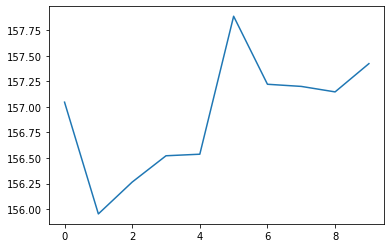

In [11]:
plt.plot(losses)

# Make predictions

In [12]:
#  PREDICT
preds = predict(model=model, dataloader=test_dl, device=device)

#  EVALUATE with error metrics
errors = calculate_all_error_metrics(
    preds,
    basin_coord="station_id",
    time_coord="time",
    obs_var="y",
    sim_var="y_hat",
    metrics=["NSE", "Pearson-r"],
)

errors.to_netcdf(data_dir / f"SOIL_MOISTURE/results/non_linear_probe_control_{hs_str}_{activation}.nc")

Calculating Errors: 100%|██████████| 668/668 [00:07<00:00, 86.88it/s, 106001]


In [14]:
from scripts.cell_state.analysis import finite_flat, histogram_plot

In [20]:
errors = xr.open_dataset(data_dir / f"SOIL_MOISTURE/results/non_linear_probe_control_{hs_str}_{activation}.nc")
control_errors = xr.open_dataset(data_dir / "SOIL_MOISTURE/results/linear_probe_control.nc")
precip_errors = xr.open_dataset(data_dir / "SOIL_MOISTURE/results/linear_probe_precipitation_sm.nc")

r = finite_flat(errors["Pearson-r"].values)
n = finite_flat(errors["NSE"].values)

cont_r = finite_flat(control_errors["Pearson-r"].values)
pcp_r = finite_flat(precip_errors["Pearson-r"].values)

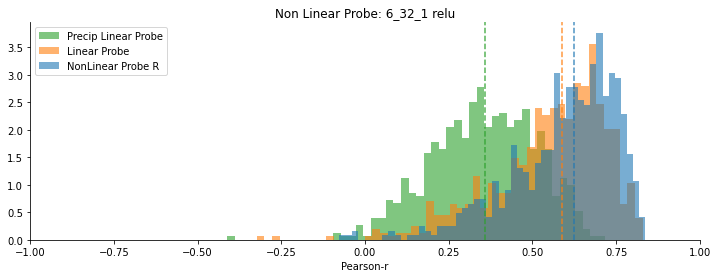

In [21]:
variable = "Pearson-r"
# variable = "NSE"

f, ax = plt.subplots(figsize=(12, 4))
if variable == "NSE":
    histogram_plot(arr=np.clip(finite_flat(precip_errors[variable].values), -1, 1), ax=ax, hist_kwargs={"color": "C2", "label": "Precip Linear Probe"})
    histogram_plot(arr=np.clip(finite_flat(control_errors[variable].values), -1, 1), ax=ax, hist_kwargs={"color": "C1", "label": "Linear Probe"})
    histogram_plot(arr=np.clip(finite_flat(errors[variable].values), -1, 1), ax=ax, hist_kwargs={"color": "C0", "label": "NonLinear Probe R"})

else:
    histogram_plot(arr=finite_flat(precip_errors[variable].values), ax=ax, hist_kwargs={"color": "C2", "label": "Precip Linear Probe"})
    histogram_plot(arr=finite_flat(control_errors[variable].values), ax=ax, hist_kwargs={"color": "C1", "label": "Linear Probe"})
    histogram_plot(arr=finite_flat(errors[variable].values), ax=ax, hist_kwargs={"color": "C0", "label": "NonLinear Probe R"})

ax.set_xlim(-1, 1)
ax.set_xlabel(variable)
ax.set_title(f"Non Linear Probe: {hs_str} {activation}")
ax.legend();

# Timeseries

In [22]:
import pickle 

lp_preds = xr.open_dataset(data_dir / "SOIL_MOISTURE/results/linear_probe_preds.nc")

# Load in LSTM SM Preds
run_dir = Path('/datadrive/data/runs/esa_cci_sm_lstm_1406_114743')
scaler = pickle.load((run_dir / "train_data/train_data_scaler.p").open("rb"))

lstm_sm_preds = xr.open_dataset(data_dir / "SOIL_MOISTURE/results/lstm_direct_sm_preds.nc")
lstm_sm_rescale = (lstm_sm_preds - scaler["xarray_feature_center"]["sm"]) / scaler["xarray_feature_scale"]["sm"]

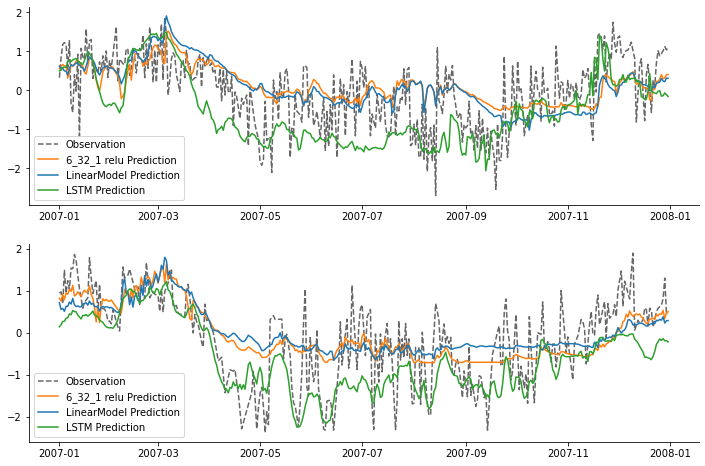

In [25]:
choices = np.random.choice(preds.station_id.values, 2)

f, axs = plt.subplots(len(choices), 1, figsize=(12, 4*len(choices)))

for i, px in enumerate(choices):
    ax = axs[i]
    data = preds.sel(station_id=px, time="2007").to_dataframe()
    lp_data = lp_preds.sel(station_id=px, time="2007").to_dataframe()
    lstm_data = lstm_sm_rescale.sel(station_id=str(px), date="2007").to_dataframe()
    
    ax.plot(data.index, data["y"], color="k", alpha=0.6, ls="--", label="Observation")
    ax.plot(data.index, data["y_hat"], label=f"{hs_str} {activation} Prediction", color="C1")
    ax.plot(lp_data.index, lp_data["y_hat"], label=f"LinearModel Prediction", color="C0")
    
#     ax2 = ax.twinx()
    ax.plot(lstm_data.index, lstm_data["sm_sim"], label=f"LSTM Prediction", color="C2")
#     ax2.plot(lstm_data.index, lstm_data["sm_obs"], label=f"LSTM obs", color="k")

    ax.legend()
    sns.despine()

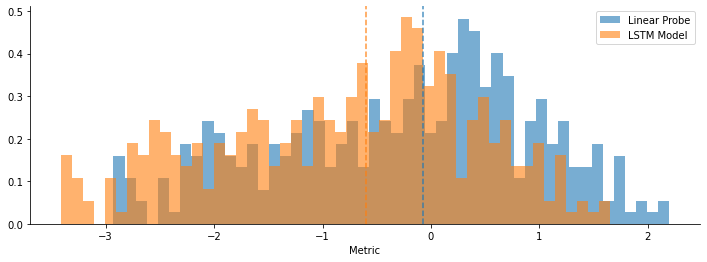

In [27]:
f, ax = plt.subplots(figsize=(12, 4))
histogram_plot(finite_flat(lp_data["y"]), ax=ax, hist_kwargs={"label": "Linear Probe", "color": "C0"})
histogram_plot(finite_flat(lstm_data["sm_obs"]), ax=ax, hist_kwargs={"label": "LSTM Model", "color": "C1"})
ax.legend()

In [30]:
display(lp_data.head())
display(lstm_data.head())

,station_id,y_hat,y
time,,,
2007-01-01,49004,0.715206,1.056789
2007-01-02,49004,0.552475,1.093659
2007-01-03,49004,0.577299,0.752012
2007-01-04,49004,0.507409,1.707547
2007-01-05,49004,0.626979,1.055578


,station_id,sm_obs,sm_sim
date,,,
2007-01-01,49004,0.522802,0.139309
2007-01-02,49004,0.559238,0.186763
2007-01-03,49004,0.221619,0.266816
2007-01-04,49004,1.165886,0.270830
2007-01-05,49004,0.521605,0.342962
